In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
from wordcloud import WordCloud

import re
from sklearn.utils import resample

In [ ]:
df = pd.read_csv('PRDECT-ID Dataset.csv')
df.head()

,Category,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Customer Review,Sentiment,Emotion
0,Computers and Laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,Jakarta Utara,53500,4.9,5449,2369,5,Alhamdulillah berfungsi dengan baik. Packaging...,Positive,Happy
1,Computers and Laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,Kota Tangerang Selatan,72000,4.9,2359,1044,5,"barang bagus dan respon cepat, harga bersaing ...",Positive,Happy
2,Computers and Laptops,SSD Midasforce 128 Gb - Tanpa Caddy,Jakarta Barat,213000,5.0,12300,3573,5,"barang bagus, berfungsi dengan baik, seler ram...",Positive,Happy
3,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,bagus sesuai harapan penjual nya juga ramah. t...,Positive,Happy
4,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",Positive,Happy


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5400 entries, 0 to 5399
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         5400 non-null   object 
 1   Product Name     5400 non-null   object 
 2   Location         5400 non-null   object 
 3   Price            5400 non-null   int64  
 4   Overall Rating   5400 non-null   float64
 5   Number Sold      5400 non-null   int64  
 6   Total Review     5400 non-null   int64  
 7   Customer Rating  5400 non-null   int64  
 8   Customer Review  5400 non-null   object 
 9   Sentiment        5400 non-null   object 
 10  Emotion          5400 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 464.2+ KB


In [ ]:
print(df.isnull().sum())
print(df.duplicated().sum())
df = df.drop_duplicates()

Category           0
Product Name       0
Location           0
Price              0
Overall Rating     0
Number Sold        0
Total Review       0
Customer Rating    0
Customer Review    0
Sentiment          0
Emotion            0
dtype: int64
7


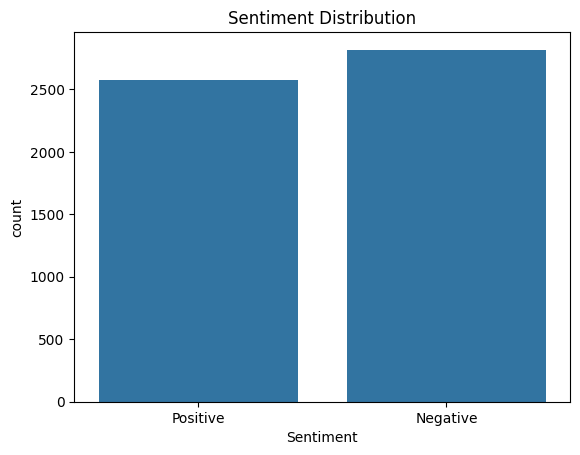

In [ ]:
# Sentiment distribution
sns.countplot(x='Sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()

Emotion counts:
 Emotion
Happy      1768
Sadness    1201
Fear        918
Love        808
Anger       698
Name: count, dtype: int64


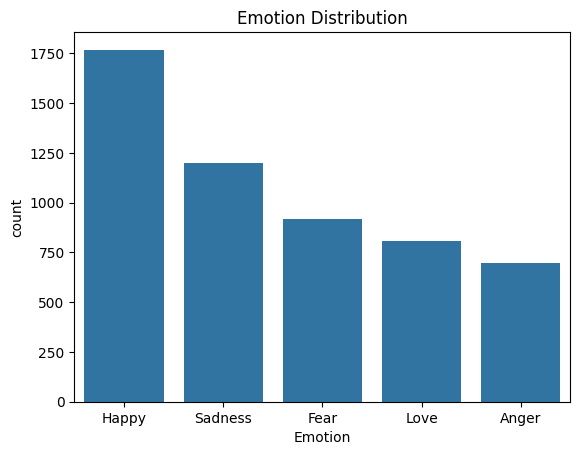

In [ ]:
# count and display exact values
emotion_counts = df['Emotion'].value_counts()
print("Emotion counts:\n", emotion_counts)

# plot emotion distribution
sns.countplot(x='Emotion', data=df, order=emotion_counts.index)
plt.title("Emotion Distribution")
plt.show()

In [ ]:
numeric_cols = ['Price', 'Overall Rating', 'Number Sold', 'Total Review', 'Customer Rating']
df[numeric_cols].describe()

,Price,Overall Rating,Number Sold,Total Review,Customer Rating
count,5.393000e+03,5393.000000,5393.000000,5393.000000,5393.000000
mean,2.388814e+05,4.854348,15968.273688,2166.188763,3.087521
std,8.021253e+05,0.108281,74248.731905,2913.132692,1.765914
min,1.000000e+02,4.100000,9.000000,4.000000,1.000000
25%,2.000000e+04,4.800000,1613.000000,576.000000,1.000000
50%,5.990000e+04,4.900000,3789.000000,1191.000000,3.000000
75%,1.500000e+05,4.900000,9707.000000,2582.000000,5.000000
max,1.539900e+07,5.000000,1000000.000000,24500.000000,5.000000


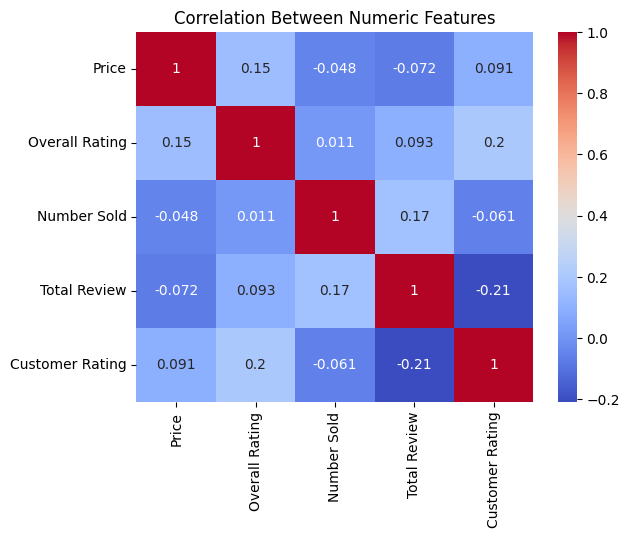

In [ ]:
# correlation heatmap
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Numeric Features")
plt.show()

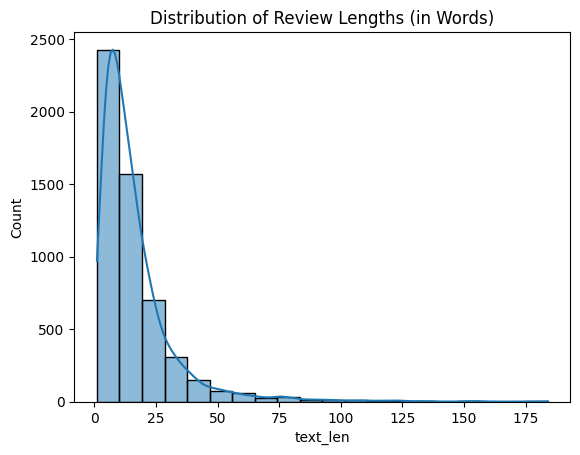

In [ ]:
df['text_len'] = df['Customer Review'].apply(lambda x: len(str(x).split()))
sns.histplot(df['text_len'], bins=20, kde=True)
plt.title("Distribution of Review Lengths (in Words)")
plt.show()

Most reviews (≈2430) are short, between 1–10 words. Only a small fraction exceed 50 words.

max_length = 64

In [ ]:
def normalize_text(s):
    s = str(s).lower()
    s = re.sub(r"http\S+|www\S+|https\S+", " <URL> ", s)
    s = re.sub(r"@\w+", " <USER> ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df['text_norm'] = df['Customer Review'].apply(normalize_text)

stopwords = set([
    "dan","yang","di","ke","dari","untuk","pada","dengan","nya","ini","itu",
    "ya","sih","lah","nih","aja","udah","karena","jadi","ada","sebagai","oleh",
    "atau","dengan","lebih","kurang","meng","ter","per","se", "kan"
])

def remove_stopwords(s):
    return ' '.join([w for w in s.split() if w not in stopwords])

df['text_no_stop'] = df['text_norm'].apply(remove_stopwords)

max_size = df['Emotion'].value_counts().max()
balanced_df = pd.concat([
    resample(
        df[df['Emotion'] == cls],
        replace=True,
        n_samples=max_size,
        random_state=42
    )
    for cls in df['Emotion'].unique()
])

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# save both original and balanced datasets
df.to_csv("product_reviews_with_norm.csv", index=False)

df[['Category','Product Name','text_norm','Sentiment','Emotion','Customer Rating']].to_csv(
    "product_reviews_canonical_text.csv", index=False)
df[['Category','Product Name','text_no_stop','Sentiment','Emotion','Customer Rating']].to_csv(
    "product_reviews_no_stop.csv", index=False)

# save balanced variants
balanced_df.to_csv("product_reviews_balanced.csv", index=False)
balanced_df[['Category','Product Name','text_norm','Sentiment','Emotion','Customer Rating']].to_csv(
    "product_reviews_balanced_canonical.csv", index=False)
balanced_df[['Category','Product Name','text_no_stop','Sentiment','Emotion','Customer Rating']].to_csv(
    "product_reviews_balanced_no_stop.csv", index=False)

In [ ]:
print("Before balancing:\n", df['Emotion'].value_counts())
print("After balancing:\n", balanced_df['Emotion'].value_counts())

Before balancing:
 Emotion
Happy      1768
Sadness    1201
Fear        918
Love        808
Anger       698
Name: count, dtype: int64
After balancing:
 Emotion
Fear       1768
Anger      1768
Happy      1768
Love       1768
Sadness    1768
Name: count, dtype: int64


In [ ]:
duplicates = balanced_df.duplicated(subset=['Customer Review']).sum()
print(f"Number of duplicated reviews after balancing: {duplicates}")

# view which reviews got duplicated
# dup_rows = balanced_df[balanced_df.duplicated(subset=['Customer Review'], keep=False)]
# dup_rows.sort_values('Customer Review').head(10)

Number of duplicated reviews after balancing: 4779
